# ZAIRA

As this wave from memories flows in, the city soaks it up like a sponge and expands. A description of Zaira as it is today should contain all Zaira’s past. The city, however, does not tell its past, but contains it like the lines of a hand, written in the corners of the streets, the gratings of the windows, the banisters of the steps, the antennae of the lightning rods, the poles of the flags, every segment marked in turn with scratches, indentations, scrolls.

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

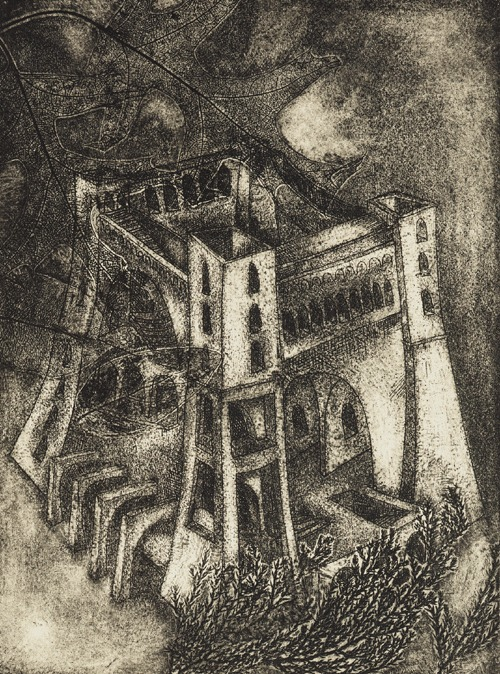

In [3]:
Image(filename='../../Images/zaira.jpg') 

### ZAIRA
        1. Reads an MCRD file produced by art/centella, which stores MCRD waveforms for PMTs (bins of 1 ns) and the SiPMs (bins of 1 mus)

        2. Simulates the response of the TRACKING plane (add gaussian and dark current noise), and produces SiPM RWF and store in output h5 file.
            
        3. Adds a table describing the SiPM FEE parameters used for simulation into the h5 output file.

        4. Monitor the input SiPM MCRD and output SiPM RFW. 
        
author: Jose A. Hernando
version: v0_00 

### Revision

In [4]:
import time
print(time.strftime("%d/%m/%Y"),' ',time.strftime("%H:%M:%S"))

10/10/2016   19:21:46


### Dependencies

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
import tables
import pandas as pd
import time
import cProfile

In [7]:
import logging
import sys
logger = logging.getLogger()
#logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [8]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
matplotlib.style.use('ggplot')

In [9]:
pp = %env PYTHONPATH
print(pp)
from Util import *
from Configure import *
from Nh5 import *

/Users/hernando/Software/root/lib:/Users/hernando/Software/lib:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Core:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Config:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Sierpe


### Inspecting the input file  

In [10]:
icdat = '/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/'
ifdat = 'nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'
h5in =tables.open_file(icdat+ifdat,'a')

In [11]:
# to inspect the h5in table, uncomment next line:
#h5in

In [12]:
# the sipm raw data table (all events)
sipmrd = h5in.root.sipmrd
# number of events, sipms, and w.f.length
nevts,nsipms,nshapes = sipmrd.shape[0],sipmrd.shape[1],sipmrd.shape[2]
print('number of events {}, number of sipms {}, wf length {}'.format(nevts,nsipms,nshapes))

# DB position of the (ordered) SiPMs 
sipmdb = h5in.root.Sensors.DataSiPM
print('DB for a SIPM index {}, {}'.format(0,sipmdb[0]))
sipms_index_map = {sipmdb[i][0] : i for i in range(nsipms) }
i0 = sipmdb[0][0]
print('index_map[{}]={}'.format(i0,sipms_index_map[i0]))

number of events 1000, number of sipms 1789, wf length 1200
DB for a SIPM index 0, (1000, 1, [-235.0, 45.0, -10000.0], 1.0, 15.5)
index_map[1000]=0


In [13]:
# Methods to operate the SiPMs data (w.fs) and DB

def sipms_qids(data,evt):
    """ returns the charge of the (ordered) sipms
    """
    sipm_evt = data[evt]
    qids = map(lambda x: sum(x),sipm_evt)
    return qids

def qids_qfilter(qids,q0=0.):
    """ returns the ids of the SiPM with total charge above q0
    """
    ids = [id for id,q in enumerate(qids) if q>q0]
    return ids

def sipms_ids_wf_(data,evt,ids):
    """ returns the wf of the SiPMs of the list ids
    """
    wfs = map(lambda i: data[evt,i],ids)
    return wfs

def sipms_id_indwf(data,evt,id,q0=0.):
    """ returns the index-w.f. a list of [(time,q),] for the selected SiPM with id in event evt
    """
    wf = data[evt][id]
    indwf = [(i,q) for i,q in enumerate(wf) if q>q0]
    return indwf

def sipms_ids_indwf(data,evt,ids,q0=0.):
    """ returns the indexed wf (a list of [(time,q),] of the list of SiPMs with ids
    """
    indwfs = map(lambda id: sipms_id_indwf(data,evt,id,q0),ids)
    return indwfs

def indwfs_trange(indwfs):
    """ returns the trange of the indexed w.fs 
    """
    xs = []
    for indwf in indwfs:
        for iwf in indwf: xs.append(iwf[0])
    trange = range(min(xs),max(xs)+1)
    return trange

def sipms_qids_slice(data,evt,islice,ids=range(nsipms)):
    """ returns a list with the charge of the SiPMs with ids (default all) in the slice (islice)
    """
    qs = map(lambda i: data[evt,i,islice], ids)
    return qs

def sipms_qids_xyq(db,qids):
    """ return a list with the (x,y,q) values from a list of the charge of the (ordered) SiPMs
    """
    vals = []
    for i in range(nsipms):
        x,y,z = db[i][2]
        q = qids[i]
        vals.append([x,y,q])
    return vals


In [14]:
sipmdat = sipmrd

In [15]:
# event to study
ievt=2
print('event {}'.format(ievt))

# total charge of all channels
qids = sipms_qids(sipmdat,ievt)
print('total charge {} '.format(sum(qids)))

event 2
total charge 1045.38805637 


In [16]:
# threshold
q0=0.
qsum0=q0*nshapes

In [17]:
# ids of the SiPMs with Q above a threshold
ids = qids_qfilter(qids,qsum0)
print('ids with q > {} : {} '.format(qsum0,ids))

# indexed w.f. of the selected SiPMs
indwfs = sipms_ids_indwf(sipmdat,ievt,ids,q0)

# range of the 
trange = indwfs_trange(indwfs)
print('time range {}'.format(trange))

# qids slices
qidslices = map(lambda islice: sipms_qids_slice(sipmdat,ievt,islice),trange)

# total charge per slice
qslices = map(sum,qidslices)
qslices = zip(trange,qslices)
print('charge per slice {}'.format(qslices))

# list [(x,y,q),] for qids (the sum)
vals = sipms_qids_xyq(sipmdb,qids)

# lists of [(x,y,q),] for the qids of the slices in trange
valslices = map(lambda qids: sipms_qids_xyq(sipmdb,qids), qidslices)

ids with q > 0.0 : [600, 601, 608, 609, 610, 616, 617, 618, 624, 625, 626, 632, 633, 678, 679, 686, 687, 694, 695, 703] 
time range [709, 710, 711, 712, 713, 714, 715, 716]
charge per slice [(709, 2.9881771802902222), (710, 68.106756985187531), (711, 235.82502117753029), (712, 372.87493285536766), (713, 247.97013932466507), (714, 96.007258117198944), (715, 19.01580885052681), (716, 2.5999618768692017)]


In [18]:
# methods to plot SiPM data

from matplotlib.mlab import griddata

def polo_qids(qids):
    """ plots charges
    1) total charge vs ID
    2) total charge distribution
    """
    plt.subplots(2,1)
    plt.subplot(2,1,1)
    plt.plot(qids)
    plt.subplot(2,1,2)
    plt.hist(qids,bins=100,log=True)
    plt.show()
    return
    
def polo_wfs(wfs,ylog=False):
    """ plots the wfs
    """
    nx = len(wfs)
    ny = 2
    plt.subplots(nx,2,figsize=(ny*4,nx*3))
    for i,wf in enumerate(wfs):
        plt.subplot(nx,ny,2*i+1)
        plt.plot(wf)
        plt.subplot(nx,ny,2*i+2)
        plt.hist(wf,100,log=ylog)
    plt.show()
    return
    
def polo_indwfs(indwfs):
    """ plots indexed wfs 
    """
    ### list of colors to display
    colors = plt.cm.Set3(np.linspace(0., 1., len(ids)))

    ### display the indexed w.fs
    for i,indwf in enumerate(indwfs):
        xs = map(lambda x: x[0],indwf)
        ys = map(lambda x: x[1],indwf)
        plt.plot(xs,ys,color=colors[i])
    plt.show()
    return

def polo_qslices(qslices):
    xs = map(lambda x:x[0],qslices)
    ys = map(lambda x:x[1],qslices)
    plt.plot(xs,ys)
    return       

def polo_xyq(vals,show=False):
    """ plots the x,y,q contour from the list (vals) of [(x,y,q),] items
    """
    xs = map(lambda i: vals[i][0],range(nsipms))
    ys = map(lambda i: vals[i][1],range(nsipms))
    zs = map(lambda i: vals[i][2],range(nsipms))
    xmin,xmax = min(xs),max(xs)
    #print('xmin {} xmax {}'.format(xmin,xmax))
    n = int(xmax-xmin)
    xi = np.linspace(xmin-0.5,xmax+0.5,n)
    yi = np.linspace(xmin-0.5,xmax+0.5,n)

    zi = griddata(xs, ys, zs, xi, yi,interp='linear')
    plt.contourf(xi, yi, zi)
    plt.colorbar()
    if (show): plt.show()
    return

def polo_xyq_slices(valslices):
    """ plots the x,y,q contour plot of several slices. 
    Each slice is a list of [(x,y,q),] items 
    """
    n = len(valslices)
    nx = int(sqrt(n))
    ny=nx
    while(nx*ny<n):ny=ny+1
    plt.subplots(nx,ny,figsize=(4*ny,3*nx))
    for i,vals in enumerate(valslices):
        plt.subplot(nx,ny,i+1)
        polo_xyq(vals)
    plt.show()
    

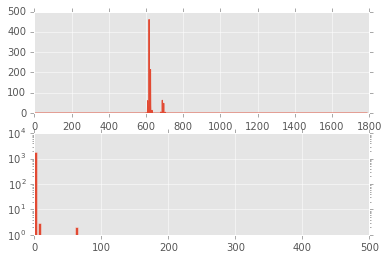

In [19]:
polo_qids(qids)

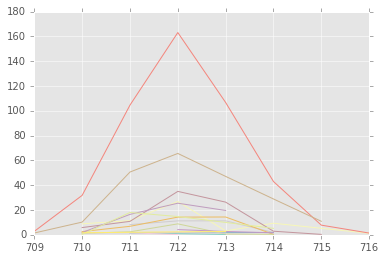

In [20]:
polo_indwfs(indwfs)

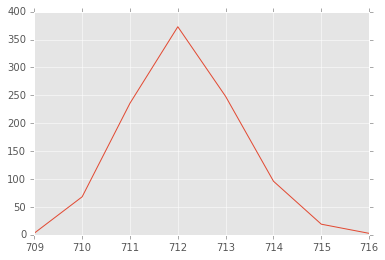

In [21]:
polo_qslices(qslices)

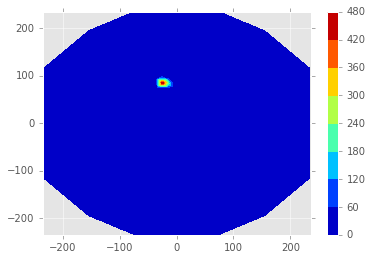

In [22]:
polo_xyq(vals)

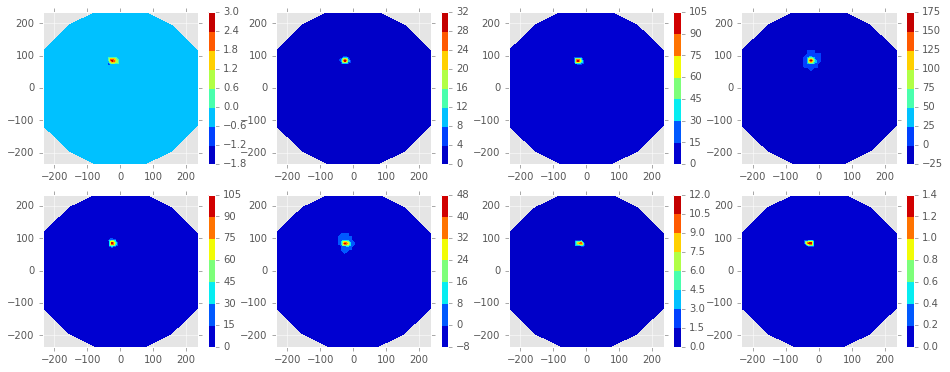

In [23]:
polo_xyq_slices(valslices)

In [24]:
h5in.close()

## SiPM FE 

In [40]:
from scipy.stats import norm,poisson

def sipm_index(sensorID):
    """ Returns the index (continous ordered SiPMs), board and sensor on board 
    from a SiPM sensorID
    """
    iboard = int(sensorID/1000)
    isensor = int(sensorID%1000)
    index = (iboard-1)*64+isensor
    return index,iboard,isensor

def sipm_sensorID(index):
    """ Returns the SiPM sensorID from the continous index, board and sensor on board
    """
    iboard = int(index/64)
    isensor = int(index%64)
    sensorid = (iboard+1)*1000+isensor
    return sensorid,iboard,isensor

#TODO: correct: it enters sensorID and transform to h5index! (8/10/16 JAH)
class FE_SiPMs:
    """ Front End SiPMs electronic simulations: gaussian noise and Dark Current
        1) noise and dark current rate are uploaded from a txt file
        2) noise is produced per SiPMs
    """
    
    def __init__(self,filename,index_map,nsamples=1200):
        """ Create a FE for SiPMs.
        nsipms: number of sipms (1792)
        nsamples: number of time samples (1200)
        tsame: integral time of each sample (1.=1 us)
        fname: file name with the data of the SiPMs noise.
            rows of sensorID, noise (in pes), and dark current rate in (us)
        """
        # tsample units is us!
        fi = open(filename)
        print('Loading DB FE SiPMS file {} ...'.format(filename))
        lines = fi.readlines()
        nsipms = len(index_map)
        # while the total SiPMs are not calibrated use the average:
        self.fe = [(0.,0.)]*nsipms
        for i in range(nsipms):
            self.fe[i] = [norm(0.,0.1),poisson(0.0324)]
        self.indexes = []
        for i,line in enumerate(lines[1:]):
            words = line.split()
            if (len(words)!=3): print('words {}'.format(words))
            sensorid,gaus,dark = int(words[0]),float(words[1]),float(words[2])
            index = index_map[sensorid]
#           print(' i {} id {} idx {} nois {} dark {} '.format(i,sensorid,index,gaus,dark))
            self.fe[index] =(norm(0.,gaus),poisson(dark))
            self.indexes.append(index)
        fi.close()
        print('Loaded  DB FE SiPMs, number of SiPMs in DB {}'.format(len(self.indexes)))
        #print(' fe {} '.format(self.fe))
        self.nsipms = nsipms
        self.nsamples = nsamples
        return
  
    def inoise(self,index):
        """ Return a wf with noise for SiPM with h5-index
        """
        gaus,pois = self.fe[index]
        return gaus.rvs(self.nsamples)+pois.rvs(self.nsamples)

    def noise(self):
        """ Returns the array with the noise for all SiPMs with nshapes!
        """
        ns = map(self.inoise,range(self.nsipms))
        return np.array(ns)

In [41]:
fe_sipms = FE_SiPMs(filename='../../myconf/DB_FESiPMs_161006.txt',
                    index_map=sipms_index_map,nsamples=12000)

def polo_fesipms():
    nsipms = len(fe_sipms.fe)
    plt.subplots(2,2,figsize=(8,6))
    print('len {}'.format(len(fe_sipms.fe)))
    nois = map(lambda i: fe_sipms.fe[i][0].std(),range(nsipms))
    plt.subplot(2,2,1)
    plt.plot(nois)
    plt.subplot(2,2,2)
    plt.hist(nois,100)
    dark = map(lambda i: fe_sipms.fe[i][1].mean(),range(nsipms))
    plt.subplot(2,2,3)
    plt.plot(dark)
    plt.subplot(2,2,4)
    plt.hist(dark,100)
    plt.show()

Loading DB FE SiPMS file ../../myconf/DB_FESiPMs_161006.txt ...
Loaded  DB FE SiPMs, number of SiPMs in DB 1705


len 1789


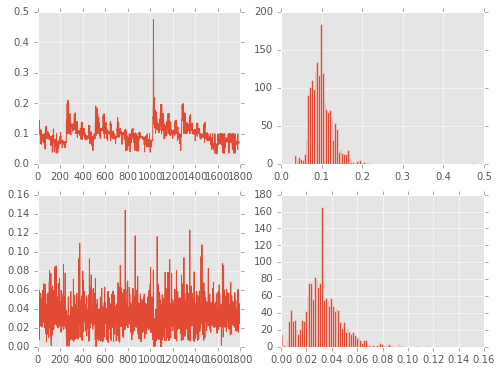

In [42]:
polo_fesipms()

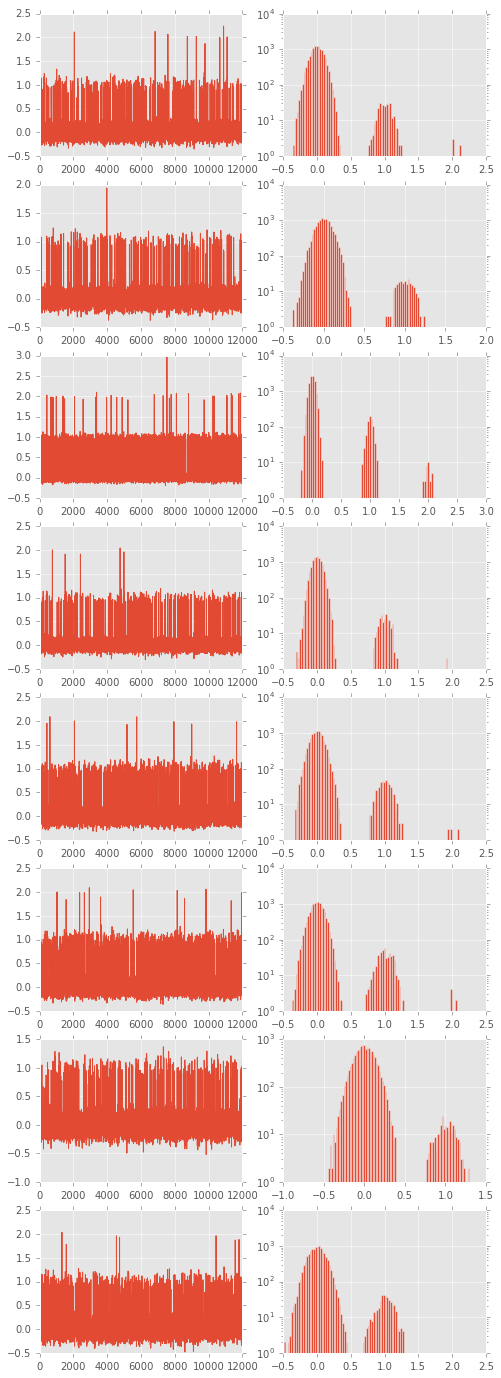

In [43]:
i0,n=64,8
wfs = fe_sipms.noise()
polo_wfs(wfs[i0:i0+n],ylog=True)

## SiPM FE - From Histograms

In [44]:
class SiPMNoiseSampler:
    def __init__(self,filename,index_map,nsamples=1200):
        print("Initializing SiPMNoiseSampler",end=" ")
        data = np.loadtxt(filename)
        self.xbins = data[0,1:]
        self.IDs   = data[1:,0]
        self.d     = np.diff(self.xbins)[0]*0.5
        self.probs = [None]*len(self.IDs)
        for i,ID in enumerate(self.IDs):
            index = index_map.get(int(ID),None)
            if index is None: continue
            self.probs[index] = data[1+i,1:]/sum(data[1+i,1:])
        while None in self.probs:
            self.probs.pop(self.probs.index(None))
        self.nsamples=nsamples
        print("DONE")
        
    def noise( self, smear = True ):
        x = np.array( [ np.random.choice(self.xbins, size=self.nsamples, p=prob) for prob in self.probs ] )
        return x if not smear else x + np.random.uniform(-self.d,self.d,size=x.shape)

In [45]:
sipms_noise_sampler_ = SiPMNoiseSampler(filename="../../myconf/NoiseSiPM_NEW.dat",
                                        index_map=sipms_index_map,nsamples=12000)

Initializing SiPMNoiseSampler DONE


/Applications/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Applications/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


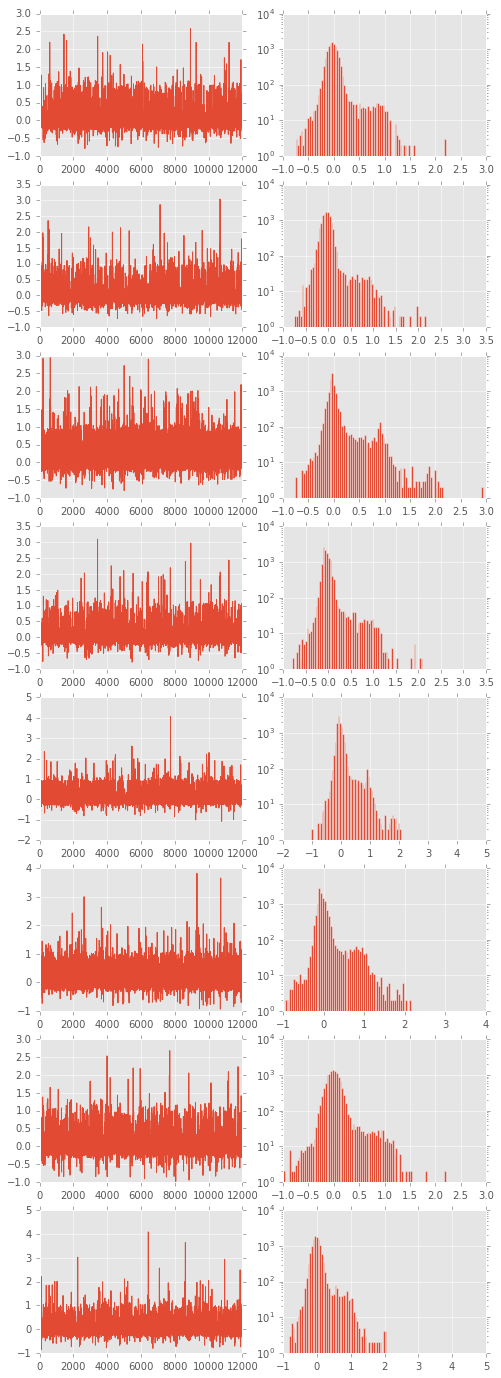

In [46]:
i0,n=64,8
wfs = sipms_noise_sampler_.noise()
polo_wfs(wfs[i0:i0+n],ylog=True)

## ZAIRA.py

In [47]:
#------

"""
ZAIRA

ChangeLog:
06/10/16 Zaira appears in
"""

def simulate_sipm_response(ievt,sipmrd_,fe):
    """
    Return the SiPM response (add noise using FE)
    """
    ns = fe.noise()
    dat = sipmrd_[ievt]
    return dat+ns

def ZAIRA(argv):
    """
    Diomira driver
    """
    DEBUG_LEVEL, INFO, CYTHON, CFP= configure(argv[0],argv[1:])
   
    if INFO:
        print("""
        ZAIRA:
        1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns) and the SiPMs (bins of 1 mus)
           
        2. Simulates the response of the tracking plane and outputs
            SiPM RWF 

        """)
        
    PATH_IN =CFP['PATH_IN']
    FILE_IN =CFP['FILE_IN']
    FIRST_EVT =CFP['FIRST_EVT']
    LAST_EVT =CFP['LAST_EVT']
    RUN_ALL =CFP['RUN_ALL']
    DB_FE_SIPM = CFP['DB_FE_SIPM']
    ##### BE CAREFUL! chaning the file we change the FE class too!!
    DB_FE_SIPM = "../../myconf/NoiseSiPM_NEW.dat"
    print('FE SIPM file {} '.format(DB_FE_SIPM))
    CLIB =CFP['CLIB']
    CLEVEL =CFP['CLEVEL']
    NEVENTS = LAST_EVT - FIRST_EVT

    # print configuration
    print('Debug level = {}'.format(DEBUG_LEVEL))
    print("input path ={} file_in ={} ".format(PATH_IN,FILE_IN))
    print("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))
    print("Compression library = {} Compression level = {} ".format(CLIB,CLEVEL))

    # open the input file 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN),"a") as h5in: 
        
        # access the SiPM raw data in file 
        sipmrd_ = h5in.root.sipmrd
        # access to SiPM DB
        sipmdb_ = h5in.root.Sensors.DataSiPM

        # number of evetns, SiPMs and w.f lenght
        NEVENTS_DST = sipmrd_.shape[0]
        NSIPM = sipmrd_.shape[1]
        SIPMWL = sipmrd_.shape[2]
        print('events {} sipms {} samples {} '.format(NEVENTS_DST,NSIPM,SIPMWL))
        SIPM_h5ID = {sipmdb_[i][0] : i for i in range(NSIPM) }

        # check that RD group exists in h5in.root
        try:
            rgroup = h5in.root.RD
        except:
            print('Creating root.RD group')
            rgroup = h5in.create_group(h5in.root, "RD")

        try:
            sipmrwf_ = h5in.root.RD.sipmrwf
            print('Removing node root.RD.sipmrwf')
            h5in.remove_node("/RD","sipmrwf")
        except tables.exceptions.NodeError:
            print('node root.RD.sipmrwf not existing')
            
        print('creating node root.RD.sipmrwf')
        # create a group to store RawData
        sipmrwf_ = h5in.create_earray(h5in.root.RD, "sipmrwf",
                                      atom=tables.Float32Atom(),
                                      shape=(0, NSIPM, SIPMWL),
                                      expectedrows=NEVENTS_DST)
            
        #create the Front End Tool for SiPMs
        TFE = SiPMNoiseSampler
        if (DB_FE_SIPM.find('DB')>=0): TFE = FE_SiPMs
        FE_SIPM = TFE(filename=DB_FE_SIPM,index_map=SIPM_h5ID,nsamples=SIPMWL)
        
        #loop in events
        print('running events first {} last {}'.format(FIRST_EVT,LAST_EVT))
        first_evt, last_evt = define_event_loop(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST,RUN_ALL)
            
        for ievt in range(first_evt,last_evt):
            logger.info("-->event number ={}".format(ievt))
            # simulate sipm response
            datasipm = simulate_sipm_response(ievt,sipmrd_,FE_SIPM)
            datasipm.astype(float)
            # add to h5 table
            sipmrwf_.append(datasipm.reshape(1, NSIPM, SIPMWL))
            
        # flush table
        sipmrwf_.flush()

    print("Leaving Zaira. Safe travels!")
    return


### Input file

In [48]:
icdat = '/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/'
ifdat = 'nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'

### Configuration file

In [135]:
# to browse the configuration file uncomment the next line:
#%less ../../Config/ZAIRA_dev.csv

### Running the script

In [49]:
ZAIRA(['ZAIRA','-i','-d','INFO','-c','../../myconf/ZAIRA_dev.csv'])


        ZAIRA:
        1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns) and the SiPMs (bins of 1 mus)
           
        2. Simulates the response of the tracking plane and outputs
            SiPM RWF 

        
FE SIPM file ../../myconf/NoiseSiPM_NEW.dat 
Debug level = INFO
input path =/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data file_in =nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5 
first event = 0 last event = 10 nof events requested = 10 
Compression library = zlib Compression level = 1 
events 1000 sipms 1789 samples 1200 
Removing node root.RD.sipmrwf
creating node root.RD.sipmrwf
Initializing SiPMNoiseSampler DONE
running events first 0 last 10
INFO:root:-->event number =0


/Applications/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Applications/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


Leaving Zaira. Safe travels!


### Checking the output file

In [50]:
h5f =tables.open_file(icdat+ifdat,'r+')
#h5f

In [51]:
sipmdb = h5f.root.Sensors.DataSiPM
sipmrwf = h5f.root.RD.sipmrwf

In [52]:
sipmdat = sipmrwf

In [53]:
# event to study
ievt=2
print('event {}'.format(ievt))

# total charge of all channels
qids = sipms_qids(sipmdat,ievt)
print('total charge {} '.format(sum(qids)))

event 2
total charge 22759.0518669 


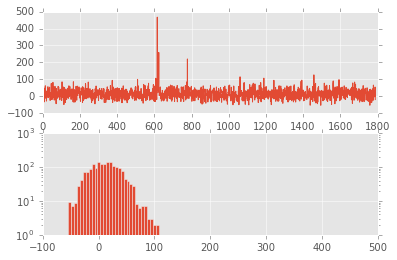

In [54]:
polo_qids(qids)

In [55]:
q0=4.5
qsum0=90
print('total charge threshold {} sample threshold {}'.format(qsum0,q0))

total charge threshold 90 sample threshold 4.5


In [56]:
# ids of the SiPMs with Q above a threshold
ids = qids_qfilter(qids,qsum0)
print('ids with q > {} : {} '.format(qsum0,ids))

# indexed w.f. of the selected SiPMs
indwfs = sipms_ids_indwf(sipmdat,ievt,ids,q0)

# range of the 
trange = indwfs_trange(indwfs)
print('time range {}'.format(trange))

ids with q > 90 : [374, 510, 608, 616, 617, 624, 778, 1061, 1189, 1243, 1393, 1458, 1562, 1593] 
time range [710, 711, 712, 713, 714, 715]


ids with q > 0.0 : [600, 601, 608, 609, 610, 616, 617, 618, 624, 625, 626, 632, 633, 678, 679, 686, 687, 694, 695, 703] 
time range [709, 710, 711, 712, 713, 714, 715, 716]

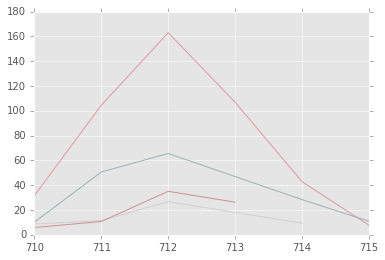

In [57]:
polo_indwfs(indwfs)

In [58]:
# qids slices
qidslices = map(lambda islice: sipms_qids_slice(sipmdat,ievt,islice),trange)

# total charge per slice
qslices = map(sum,qidslices)
qslices = zip(trange,qslices)
print('charge per slice {}'.format(qslices))

charge per slice [(710, 103.29560736420535), (711, 252.80384446332027), (712, 384.4227984655372), (713, 260.35011193566243), (714, 94.623474678126513), (715, 29.230831253957149)]


charge per slice [(709, 2.9881771802902222), (710, 68.106756985187531), (711, 235.82502117753029), (712, 372.87493285536766), (713, 247.97013932466507), (714, 96.007258117198944), (715, 19.01580885052681), (716, 2.5999618768692017)]

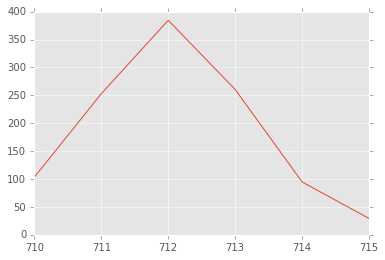

In [59]:
polo_qslices(qslices)

In [60]:
# list [(x,y,q),] for qids (the sum)
vals = sipms_qids_xyq(sipmdb,qids)

# lists of [(x,y,q),] for the qids of the slices in trange
valslices = map(lambda qids: sipms_qids_xyq(sipmdb,qids), qidslices)

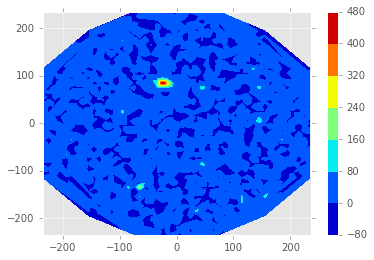

In [61]:
polo_xyq(vals)

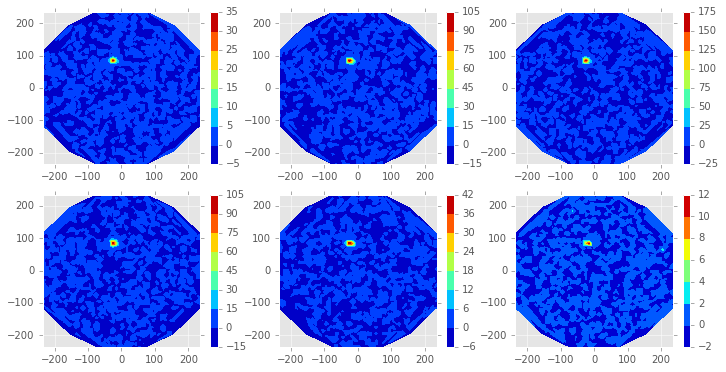

In [62]:
polo_xyq_slices(valslices)

In [63]:
h5f.close()

That's all folks!